In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather-data-task-01/weather_data.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectFromModel, RFE
from datetime import datetime, timedelta
from scipy import stats
from pandas.plotting import autocorrelation_plot
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# Load dataset
file_path = "/kaggle/input/weather-data-task-01/weather_data.csv"
data = pd.read_csv(file_path)

In [4]:
# Initial data exploration
print("Initial Data Shape:", data.shape)
print("\nData Types:")
print(data.dtypes)
print("\nMissing Values:")
print(data.isnull().sum())
print("\nSample Data:")
print(data.head())

Initial Data Shape: (311, 7)

Data Types:
date                object
avg_temperature    float64
humidity           float64
avg_wind_speed     float64
rain_or_not         object
cloud_cover        float64
pressure           float64
dtype: object

Missing Values:
date                0
avg_temperature    15
humidity           15
avg_wind_speed     15
rain_or_not         0
cloud_cover        15
pressure            0
dtype: int64

Sample Data:
         date  avg_temperature   humidity  avg_wind_speed rain_or_not  \
0  2023-01-01        23.745401  46.140905        7.845981        Rain   
1  2023-01-02        30.030503  59.876587        5.382457        Rain   
2  2023-01-03        28.365224  51.464618       13.158008        Rain   
3  2023-01-04        27.550929  53.103799        5.886677        Rain   
4  2023-01-05        23.639303  57.826186       12.248992        Rain   

   cloud_cover     pressure  
0    20.851051   992.965681  
1    93.059521  1037.273025  
2    11.636640  1034.193357 

In [5]:
# Convert 'date' to datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')

In [6]:
# Standardize the 'rain_or_not' column - ensuring consistent encoding
data['rain_or_not'] = data['rain_or_not'].str.strip() if isinstance(data['rain_or_not'].iloc[0], str) else data['rain_or_not']
data['rain_or_not'] = data['rain_or_not'].apply(
    lambda x: 1 if (isinstance(x, str) and x.lower() == 'rain') or x == 1 else 0
)

In [7]:
data.head()

,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
0,2023-01-01,23.745401,46.140905,7.845981,1,20.851051,992.965681
1,2023-01-02,30.030503,59.876587,5.382457,1,93.059521,1037.273025
2,2023-01-03,28.365224,51.464618,13.158008,1,11.636640,1034.193357
3,2023-01-04,27.550929,53.103799,5.886677,1,81.744971,968.610142
4,2023-01-05,23.639303,57.826186,12.248992,1,38.062329,1030.264331


In [8]:
# Check for duplicate dates and handle if needed
duplicate_dates = data.duplicated(subset=['date'], keep=False)
if duplicate_dates.any():
    print(f"Found {duplicate_dates.sum()} duplicate dates.")
    # Taking the average for numeric columns for duplicate dates
    data = data.groupby('date').agg({
        'avg_temperature': 'mean',
        'humidity': 'mean',
        'avg_wind_speed': 'mean', 
        'cloud_cover': 'mean' if 'cloud_cover' in data.columns else 'first',
        'pressure': 'mean' if 'pressure' in data.columns else 'first',
        'rain_or_not': 'max'  # If any entry indicates rain, consider it rained
    }).reset_index()

In [9]:
# Sort data by date to ensure chronological order
data = data.sort_values(by='date')

In [10]:
# ----- EDA: Exploratory Data Analysis -----
print("\n----- Exploratory Data Analysis -----")

# Summary statistics
print("\nSummary Statistics:")
print(data.describe())


----- Exploratory Data Analysis -----

Summary Statistics:
                      date  avg_temperature    humidity  avg_wind_speed  \
count                  311       296.000000  296.000000      296.000000   
mean   2023-06-05 00:00:00        25.983840   55.041385        7.556636   
min    2023-01-01 00:00:00        15.000000   30.000000        0.069480   
25%    2023-03-19 12:00:00        20.265692   34.280826        3.550354   
50%    2023-06-05 00:00:00        27.177958   56.759806        7.326421   
75%    2023-08-21 12:00:00        32.204599   72.189837       11.050627   
max    2023-11-07 00:00:00        35.000000   90.000000       56.636041   
std                    NaN         6.802475   19.220133        5.344683   

       rain_or_not  cloud_cover     pressure  
count   311.000000   296.000000   311.000000  
mean      0.636656    49.834827  1001.059119  
min       0.000000     0.321826   951.240404  
25%       0.000000    24.530951   975.757545  
50%       1.000000    50.7251

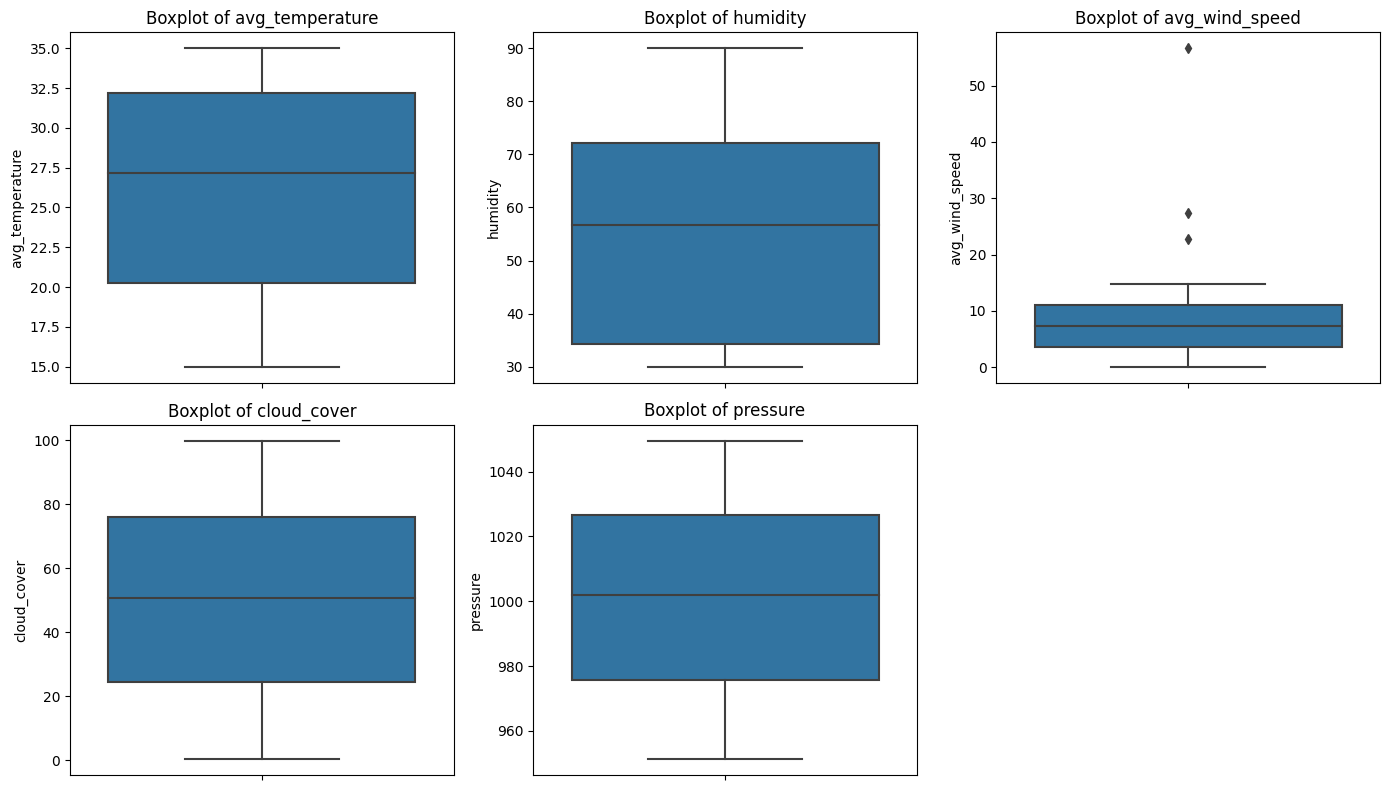

In [11]:
# Check for outliers in numerical columns
numerical_cols = ['avg_temperature', 'humidity', 'avg_wind_speed']
if 'cloud_cover' in data.columns:
    numerical_cols.append('cloud_cover')
if 'pressure' in data.columns:
    numerical_cols.append('pressure')

plt.figure(figsize=(14, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=data[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()
plt.savefig('outliers_boxplot.png')
plt.close()


In [12]:
# Advanced outlier detection and handling
print("\nHandling outliers with z-score method...")
for col in numerical_cols:
    z_scores = stats.zscore(data[col], nan_policy='omit')
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3)
    data.loc[~filtered_entries, col] = data[col].quantile(0.95) if data.loc[~filtered_entries, col].mean() > data[col].mean() else data[col].quantile(0.05)


Handling outliers with z-score method...


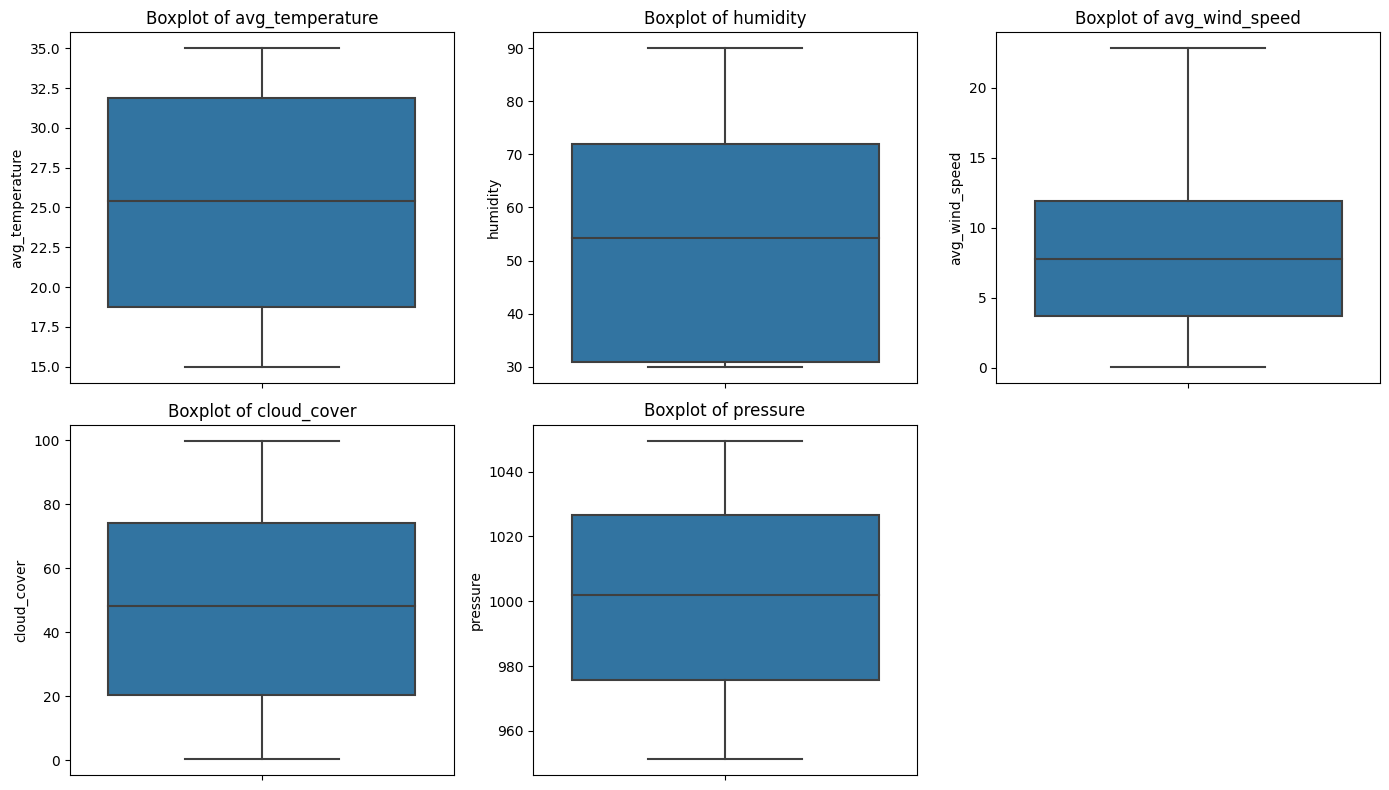

In [13]:
plt.figure(figsize=(14, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=data[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()
plt.savefig('outliers_removed_boxplot.png')
plt.close()

In [14]:
# Additional basic domain-knowledge based outlier removal
print("\nRemoving extreme outliers based on domain knowledge...")
data = data[(data['avg_temperature'] >= -50) & (data['avg_temperature'] <= 60)]  # Realistic temperature range
data = data[(data['humidity'] >= 0) & (data['humidity'] <= 100)]  # Humidity is a percentage
data = data[data['avg_wind_speed'] >= 0]  # Wind speed can't be negative


Removing extreme outliers based on domain knowledge...


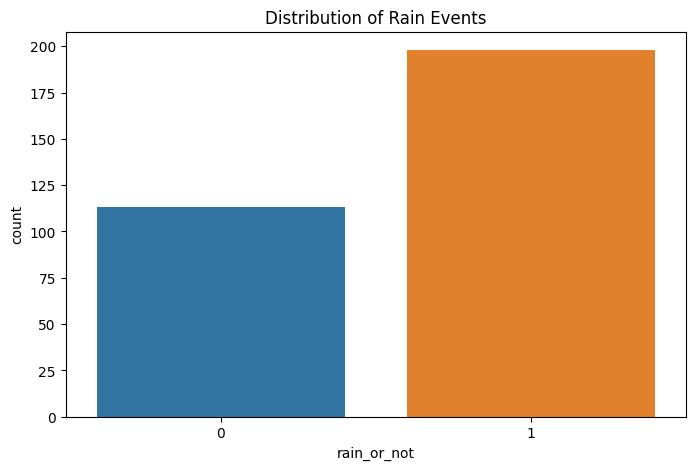

In [15]:
# Distribution of target variable
plt.figure(figsize=(8, 5))
sns.countplot(x='rain_or_not', data=data)
plt.title('Distribution of Rain Events')
plt.show()
plt.savefig('rain_distribution.png')
plt.close()

In [16]:
print(f"\nTarget distribution: {data['rain_or_not'].value_counts(normalize=True) * 100}")


Target distribution: rain_or_not
1    63.665595
0    36.334405
Name: proportion, dtype: float64


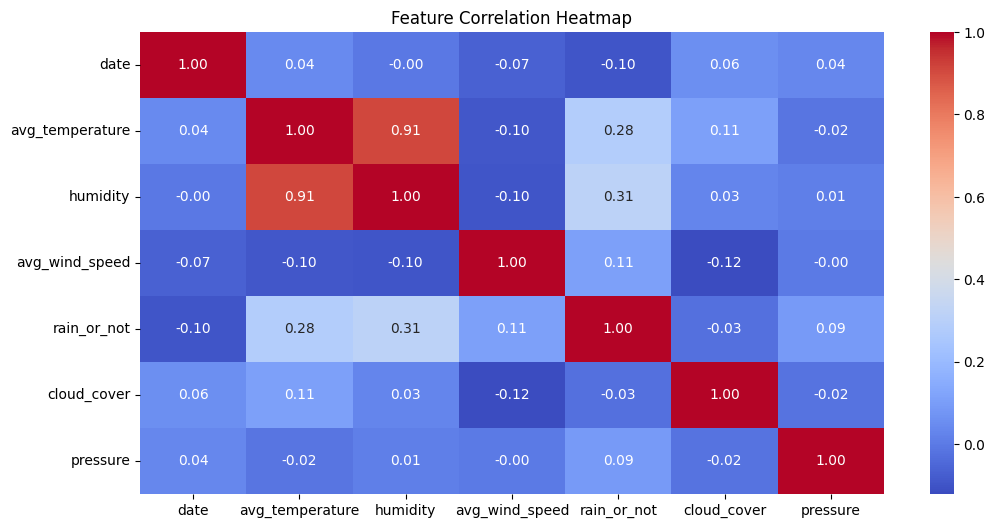

In [17]:
# Correlation analysis

plt.figure(figsize=(12, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()
plt.show()
plt.savefig('correlation_matrix.png')
plt.close()


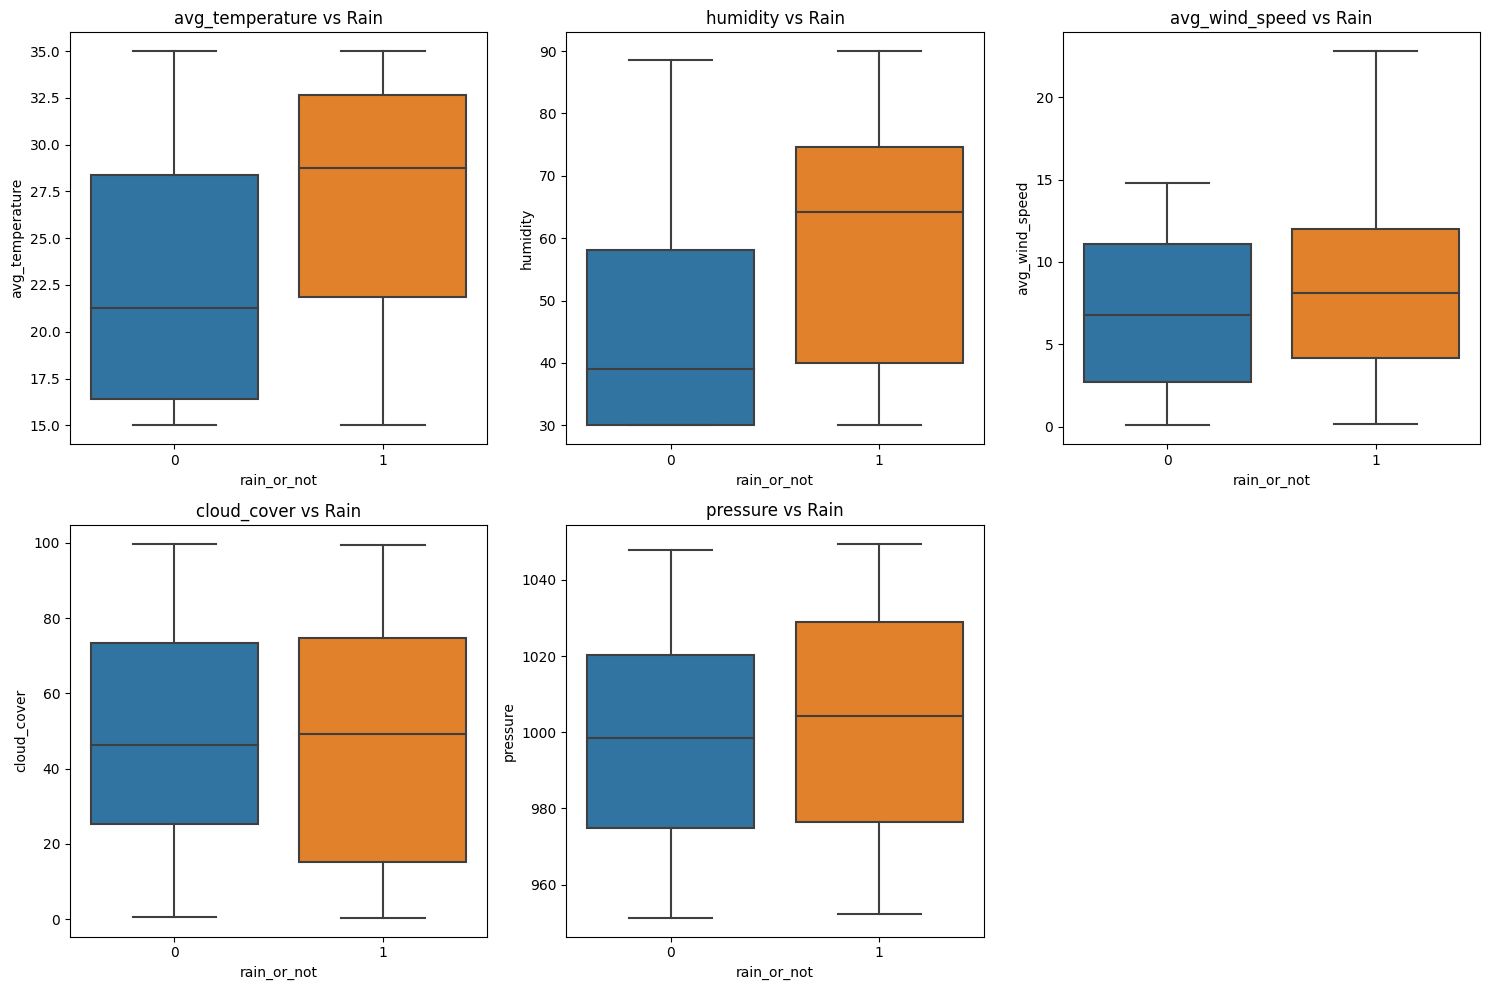

In [18]:
# Visualize relationships between features and target
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='rain_or_not', y=col, data=data)
    plt.title(f'{col} vs Rain')
plt.tight_layout()
plt.show()
plt.savefig('features_vs_target.png')
plt.close()

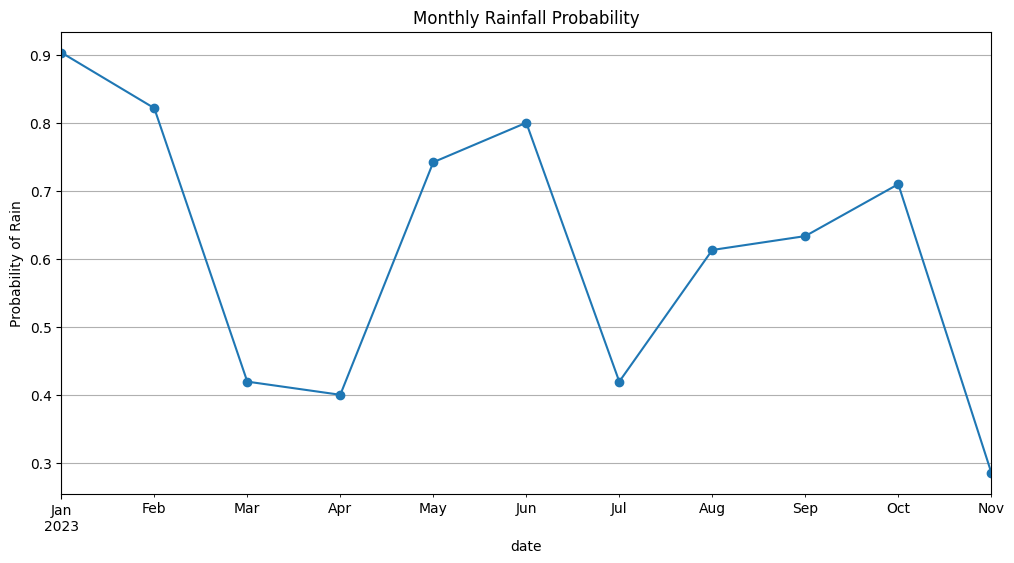

In [19]:
# Add rainfall pattern analysis
plt.figure(figsize=(12, 6))
rain_pattern = data.groupby(data['date'].dt.to_period('M'))['rain_or_not'].mean()
rain_pattern.plot(kind='line', marker='o')
plt.title('Monthly Rainfall Probability')
plt.ylabel('Probability of Rain')
plt.grid(True)
plt.show()
plt.savefig('monthly_rain_pattern.png')
plt.close()

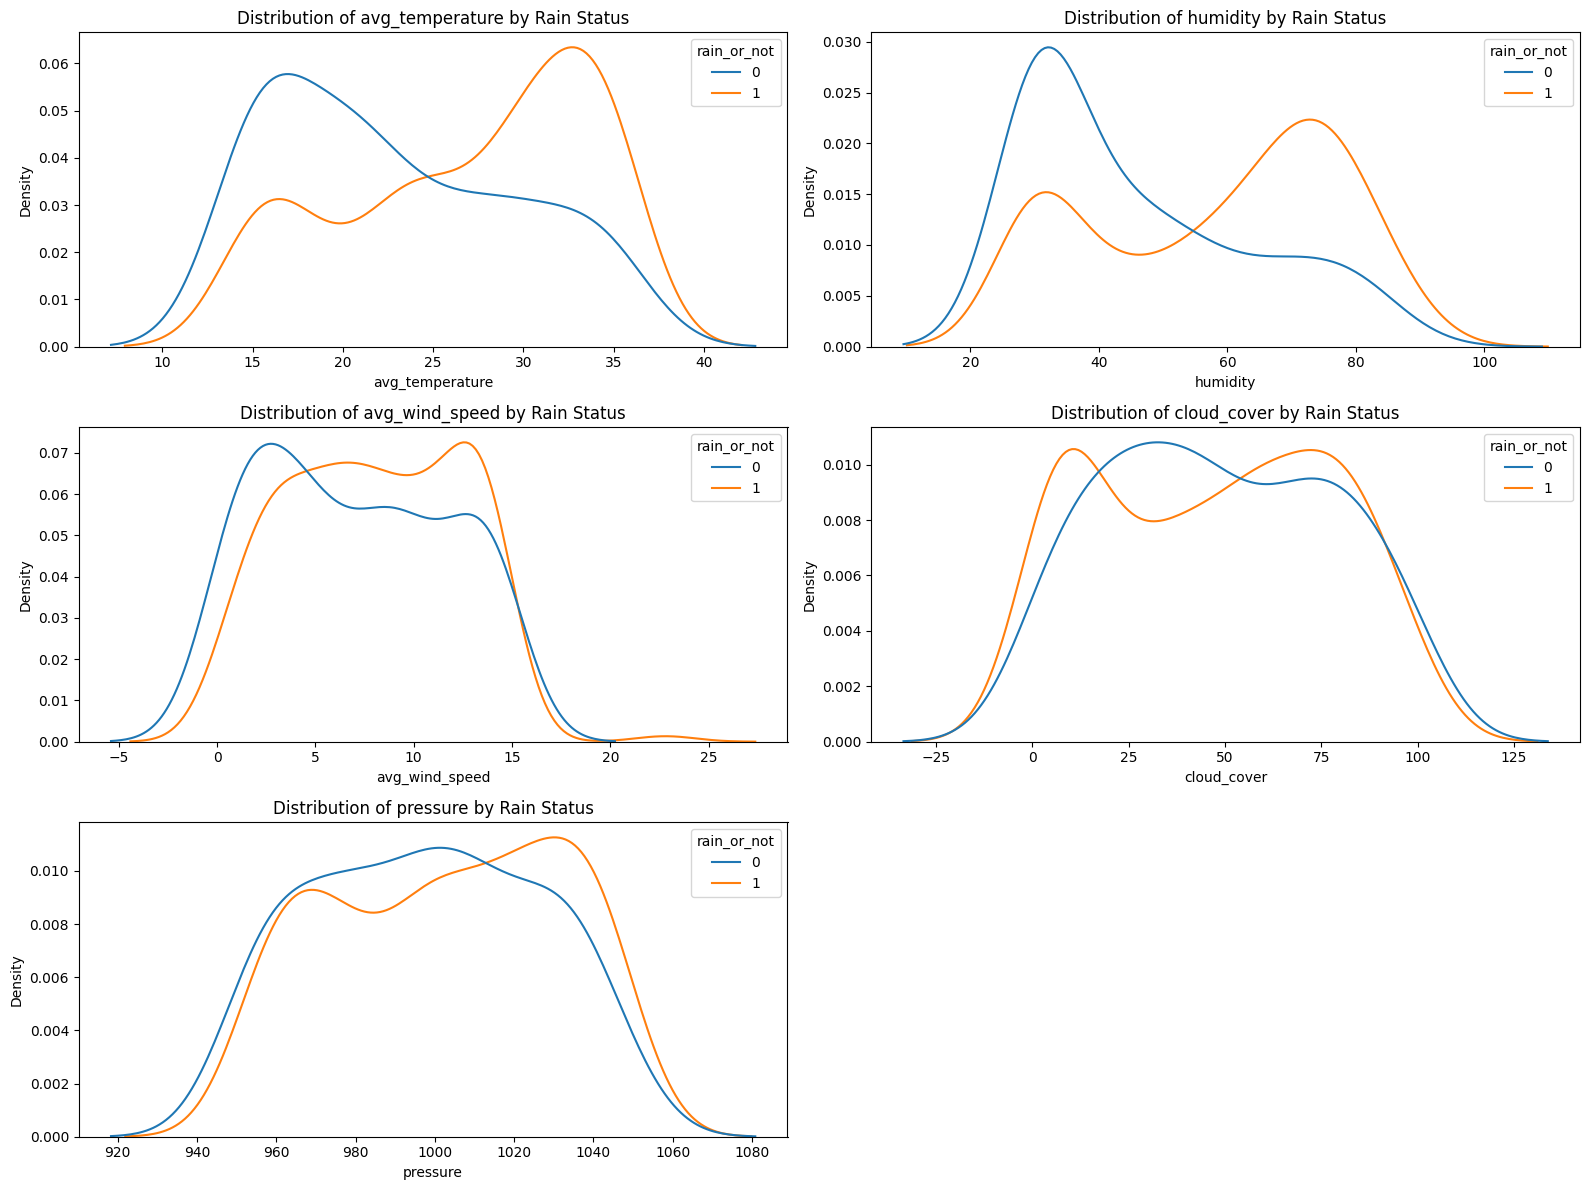

In [20]:
# Analyze feature distributions by rain/no rain
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 2, i+1)
    sns.kdeplot(data=data, x=col, hue='rain_or_not', common_norm=False)
    plt.title(f'Distribution of {col} by Rain Status')
plt.tight_layout()
plt.show()
plt.savefig('feature_distributions_by_rain.png')
plt.close()

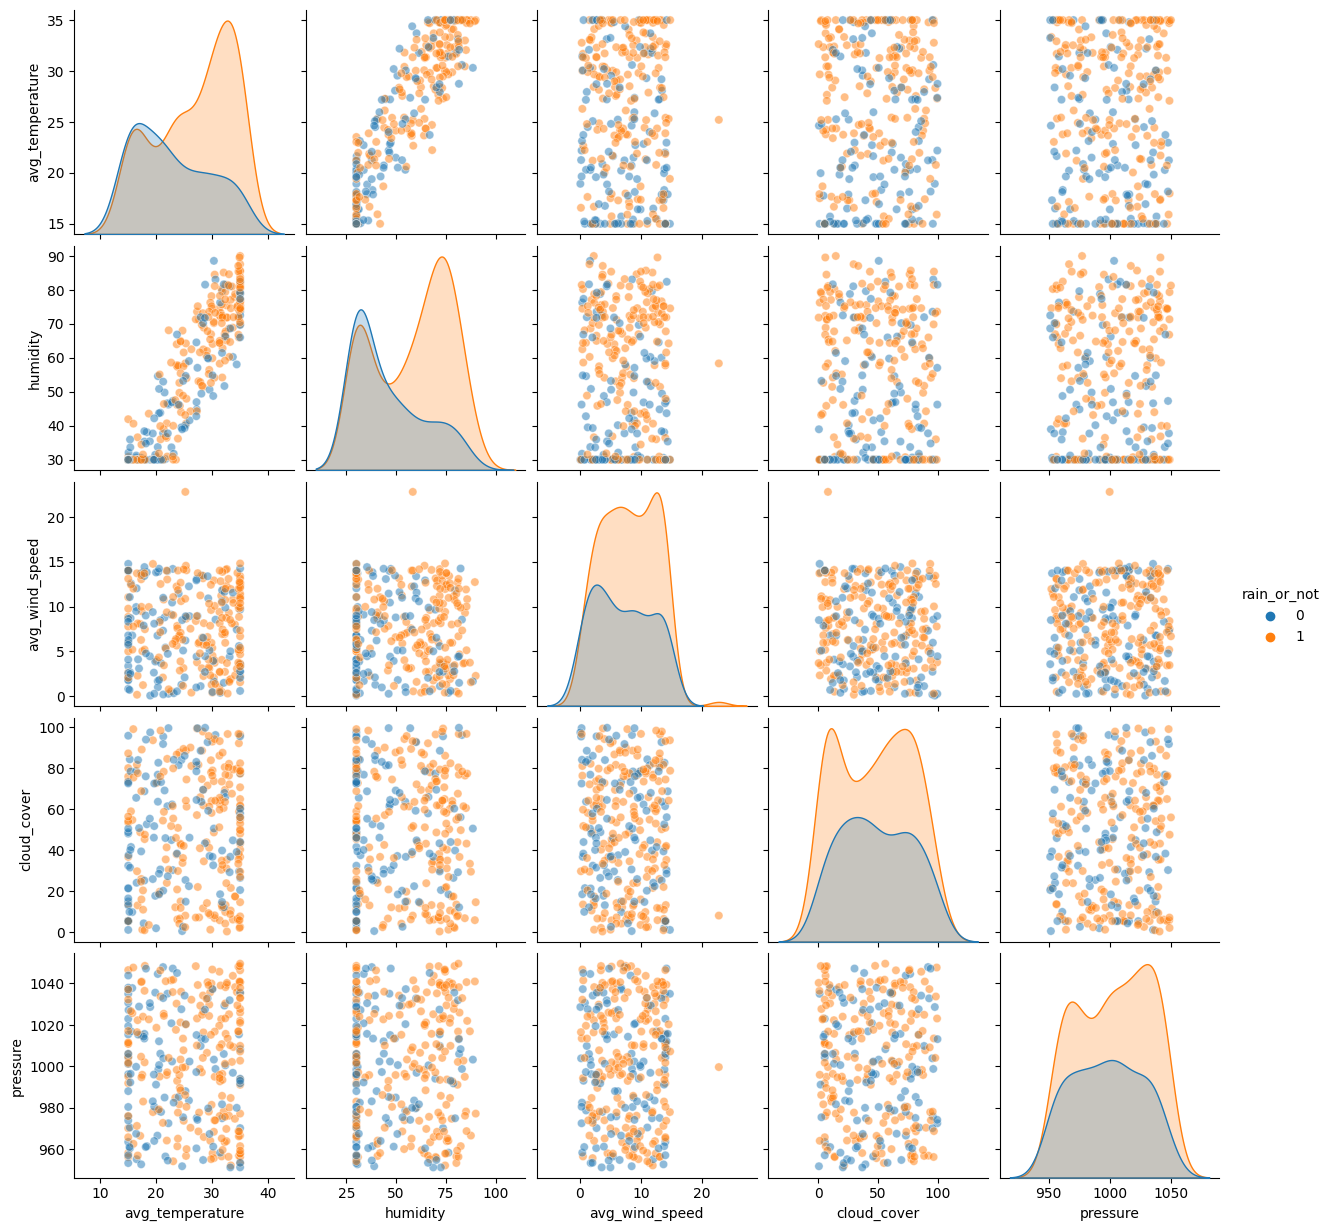

In [21]:
# Add pair plot for multivariate analysis
sns.pairplot(data[numerical_cols + ['rain_or_not']], hue='rain_or_not', plot_kws={'alpha': 0.5})
plt.show()
plt.savefig('pairplot.png')
plt.close()

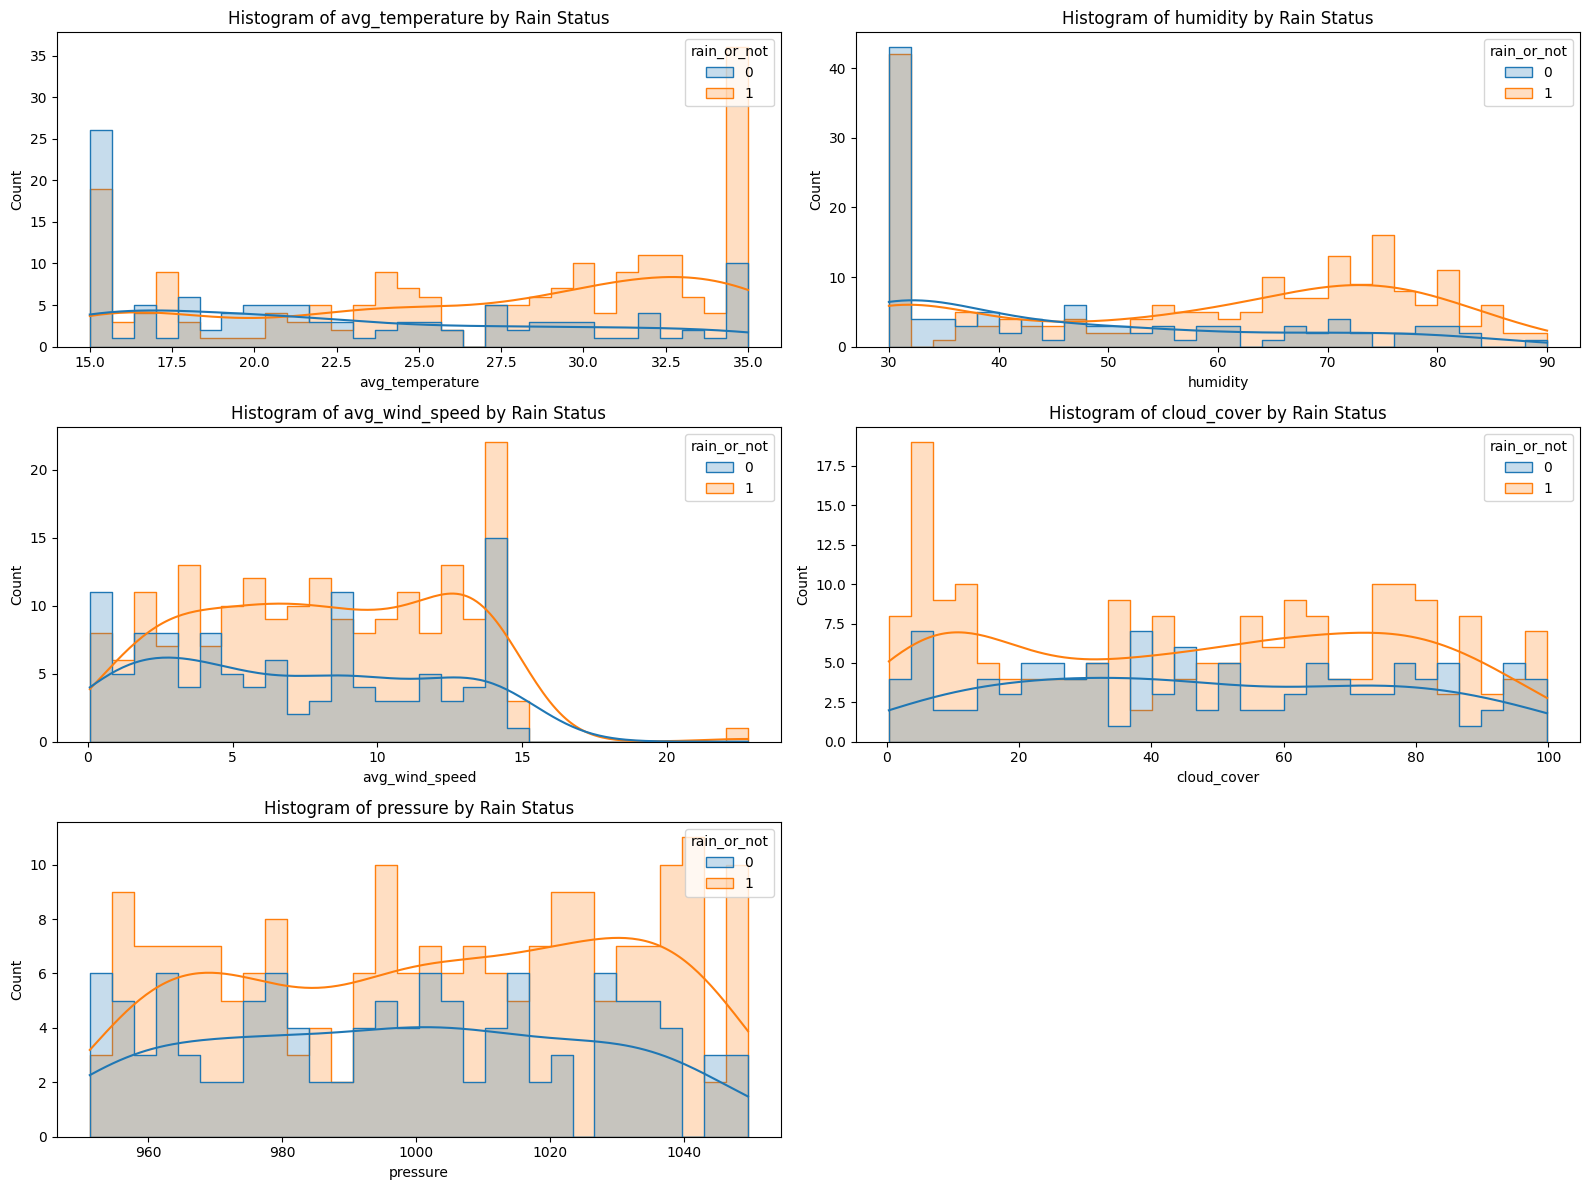

In [22]:
# Histogram analysis for numerical features
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 2, i+1)
    sns.histplot(data=data, x=col, hue='rain_or_not', kde=True, element="step", bins=30)
    plt.title(f'Histogram of {col} by Rain Status')
plt.tight_layout()
plt.show()
plt.savefig('feature_histograms_by_rain.png')
plt.close()

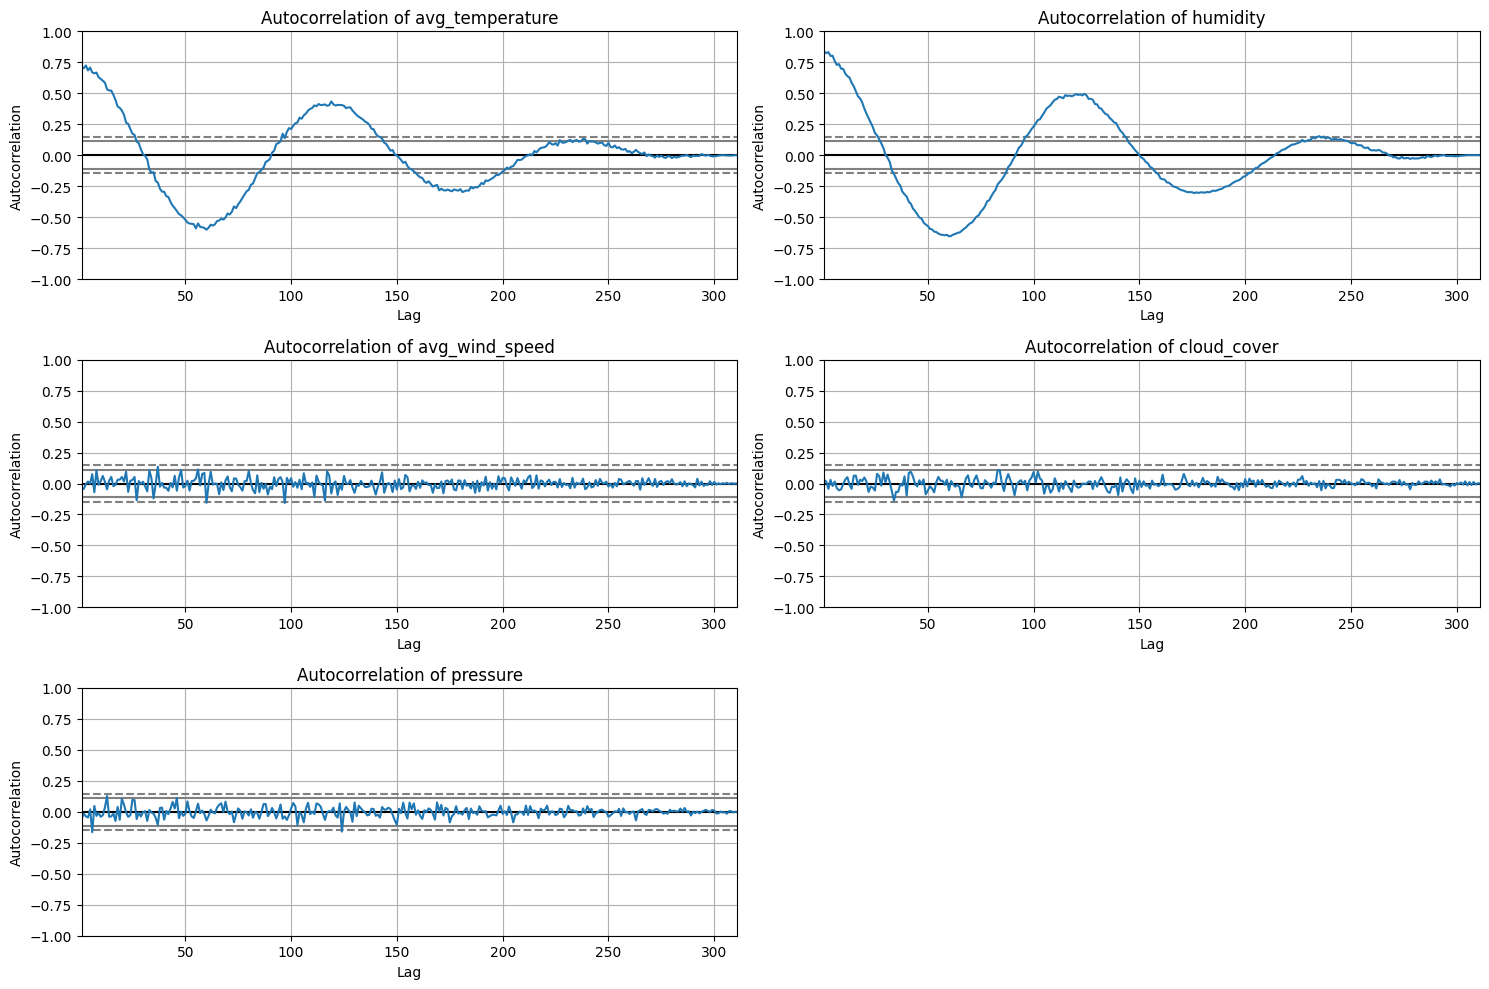

In [23]:
# Analyze autocorrelation for time series features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 2, i+1)  # Changed from (2, 2) to (3, 2) to accommodate up to 6 columns
    autocorrelation_plot(data[col])
    plt.title(f'Autocorrelation of {col}')
plt.tight_layout()
plt.show()
plt.savefig('autocorrelation.png')
plt.close()


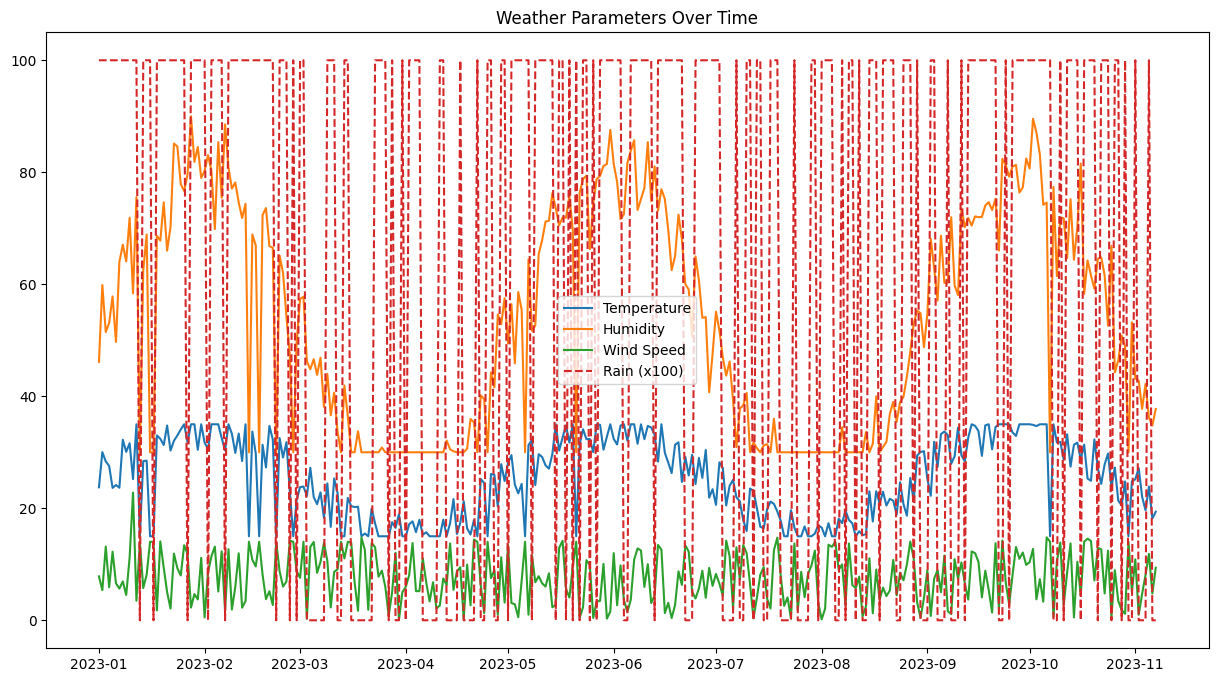

In [24]:
# Time series analysis
plt.figure(figsize=(15, 8))
plt.plot(data['date'], data['avg_temperature'], label='Temperature')
plt.plot(data['date'], data['humidity'], label='Humidity')
plt.plot(data['date'], data['avg_wind_speed'], label='Wind Speed')
plt.plot(data['date'], data['rain_or_not'] * 100, label='Rain (x100)', linestyle='--')  # Scaled for visibility
plt.legend()
plt.title('Weather Parameters Over Time')
plt.show()
plt.savefig('time_series.png')
plt.close()

In [25]:
# Seasonal patterns (if data spans multiple years)
if data['date'].dt.year.nunique() > 1:
    plt.figure(figsize=(12, 6))
    data.groupby(data['date'].dt.month)['rain_or_not'].mean().plot(kind='bar')
    plt.title('Monthly Rain Probability')
    plt.xlabel('Month')
    plt.ylabel('Probability of Rain')
    plt.show()
    plt.savefig('monthly_rain_probability.png')
    plt.close()


In [26]:
# ----- Data Preprocessing -----
print("\n----- Data Preprocessing -----")

# Advanced imputation for missing values
print("Handling missing values with iterative imputation...")
# Use Iterative Imputer for sophisticated imputation
imputer = IterativeImputer(max_iter=10, random_state=42)
data[numerical_cols] = imputer.fit_transform(data[numerical_cols])



----- Data Preprocessing -----
Handling missing values with iterative imputation...


In [27]:
data.isnull().sum()

date               0
avg_temperature    0
humidity           0
avg_wind_speed     0
rain_or_not        0
cloud_cover        0
pressure           0
dtype: int64

In [28]:
# Apply transformations for better normalization
print("\nApplying normalization transformations...")
for col in numerical_cols:
    if data[col].min() < 0:
        pt = PowerTransformer(method='yeo-johnson')
        data[col] = pt.fit_transform(data[col].values.reshape(-1, 1))


Applying normalization transformations...


In [29]:
# Feature Engineering
print("\nPerforming feature engineering...")

# Date-based features
data['day_of_year'] = data['date'].dt.dayofyear
data['month'] = data['date'].dt.month
data['day_of_week'] = data['date'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
data['season'] = data['month'].apply(lambda x: 1 if x in [12, 1, 2] else 
                                     (2 if x in [3, 4, 5] else 
                                      (3 if x in [6, 7, 8] else 4)))


Performing feature engineering...


In [30]:
# Add cyclical encoding for date features
data['month_sin'] = np.sin(2 * np.pi * data['month']/12)
data['month_cos'] = np.cos(2 * np.pi * data['month']/12)
data['day_sin'] = np.sin(2 * np.pi * data['day_of_year']/365)
data['day_cos'] = np.cos(2 * np.pi * data['day_of_year']/365)


In [31]:
# Add meteorological formulas for better prediction
# Calculate dew point temperature (improved formula)
gamma = 17.27
beta = 237.7  # °C
data['dew_point'] = data.apply(lambda row: (beta * (np.log(row['humidity']/100) + 
                                                  ((gamma * row['avg_temperature'])/
                                                   (beta + row['avg_temperature']))))/
                             (gamma - np.log(row['humidity']/100) - 
                              ((gamma * row['avg_temperature'])/
                               (beta + row['avg_temperature']))), axis=1)


In [32]:
# Calculate vapor pressure
data['vapor_pressure'] = 6.11 * 10**((7.5 * data['avg_temperature'])/(237.3 + data['avg_temperature']))

# Calculate wind chill factor
data['wind_chill'] = 13.12 + 0.6215 * data['avg_temperature'] - 11.37 * data['avg_wind_speed']**0.16 + 0.3965 * data['avg_temperature'] * data['avg_wind_speed']**0.16

# Lag features (previous days)
for lag in range(1, 4):  # Create features for previous 3 days
    for col in numerical_cols:
        data[f'{col}_lag_{lag}'] = data[col].shift(lag)
        # Rate of change
        data[f'{col}_roc_{lag}'] = data[col] / data[col].shift(lag) - 1
    data[f'rain_lag_{lag}'] = data['rain_or_not'].shift(lag)

# Rolling averages and exponentially weighted features
for window in [3, 7]:
    for col in numerical_cols:
        data[f'{col}_rolling_{window}'] = data[col].rolling(window=window).mean()
    data[f'rain_rolling_{window}'] = data['rain_or_not'].rolling(window=window).mean()

for alpha in [0.3, 0.7]:
    for col in numerical_cols:
        data[f'{col}_ewm_{int(alpha*10)}'] = data[col].ewm(alpha=alpha).mean()

In [33]:
# Interaction features
data['humidity_temp_interaction'] = data['humidity'] * data['avg_temperature']
data['wind_humidity_interaction'] = data['avg_wind_speed'] * data['humidity']

# Drop rows with NaN values (mostly from lag features)
data.dropna(inplace=True)

# Check new features
print("\nNew dataset shape after feature engineering:", data.shape)
print("New features added:", [col for col in data.columns if col not in ['date', 'rain_or_not'] + numerical_cols])


New dataset shape after feature engineering: (305, 76)
New features added: ['day_of_year', 'month', 'day_of_week', 'is_weekend', 'season', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'dew_point', 'vapor_pressure', 'wind_chill', 'avg_temperature_lag_1', 'avg_temperature_roc_1', 'humidity_lag_1', 'humidity_roc_1', 'avg_wind_speed_lag_1', 'avg_wind_speed_roc_1', 'cloud_cover_lag_1', 'cloud_cover_roc_1', 'pressure_lag_1', 'pressure_roc_1', 'rain_lag_1', 'avg_temperature_lag_2', 'avg_temperature_roc_2', 'humidity_lag_2', 'humidity_roc_2', 'avg_wind_speed_lag_2', 'avg_wind_speed_roc_2', 'cloud_cover_lag_2', 'cloud_cover_roc_2', 'pressure_lag_2', 'pressure_roc_2', 'rain_lag_2', 'avg_temperature_lag_3', 'avg_temperature_roc_3', 'humidity_lag_3', 'humidity_roc_3', 'avg_wind_speed_lag_3', 'avg_wind_speed_roc_3', 'cloud_cover_lag_3', 'cloud_cover_roc_3', 'pressure_lag_3', 'pressure_roc_3', 'rain_lag_3', 'avg_temperature_rolling_3', 'humidity_rolling_3', 'avg_wind_speed_rolling_3', 'cloud_cov

In [34]:
# ----- Feature Selection -----
print("\n----- Feature Selection -----")

# Separate features and target
X = data.drop(columns=['rain_or_not', 'date'])
y = data['rain_or_not']

# Check for multicollinearity and remove highly correlated features
corr_matrix = X.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_cols = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]

print(f"Removing {len(high_corr_cols)} highly correlated features: {high_corr_cols}")
X = X.drop(columns=high_corr_cols)



----- Feature Selection -----
Removing 27 highly correlated features: ['humidity', 'month', 'season', 'month_sin', 'day_sin', 'day_cos', 'dew_point', 'vapor_pressure', 'wind_chill', 'humidity_lag_1', 'humidity_lag_2', 'humidity_lag_3', 'avg_temperature_rolling_3', 'humidity_rolling_3', 'avg_temperature_rolling_7', 'humidity_rolling_7', 'avg_temperature_ewm_3', 'humidity_ewm_3', 'avg_wind_speed_ewm_3', 'cloud_cover_ewm_3', 'pressure_ewm_3', 'avg_temperature_ewm_7', 'humidity_ewm_7', 'avg_wind_speed_ewm_7', 'cloud_cover_ewm_7', 'pressure_ewm_7', 'humidity_temp_interaction']


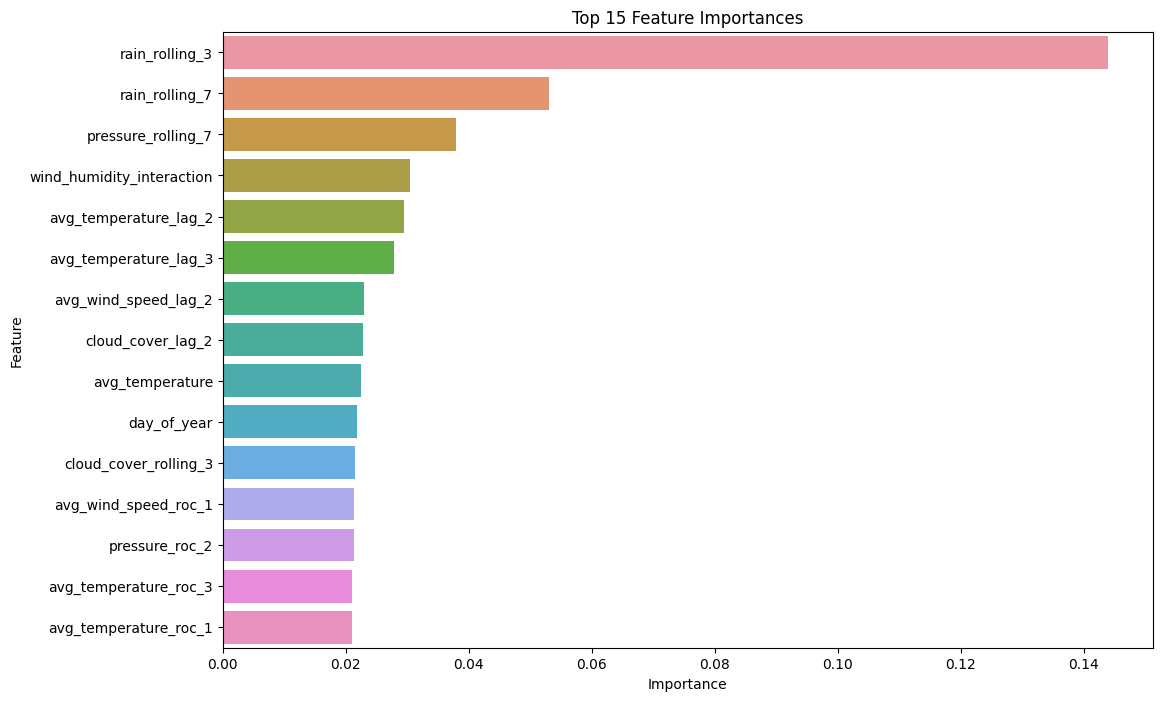

In [35]:
# Feature importance using Random Forest
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X, y)
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_selector.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance.head(15))
plt.title('Top 15 Feature Importances')
plt.show()
plt.savefig('feature_importance.png')
plt.close()

In [36]:
# Select top features
top_features = importance['Feature'].head(15).tolist()
print("\nTop 15 features:", top_features)



Top 15 features: ['rain_rolling_3', 'rain_rolling_7', 'pressure_rolling_7', 'wind_humidity_interaction', 'avg_temperature_lag_2', 'avg_temperature_lag_3', 'avg_wind_speed_lag_2', 'cloud_cover_lag_2', 'avg_temperature', 'day_of_year', 'cloud_cover_rolling_3', 'avg_wind_speed_roc_1', 'pressure_roc_2', 'avg_temperature_roc_3', 'avg_temperature_roc_1']


In [37]:
# Prepare final dataset
X_selected = X[top_features]

# Split data chronologically (not randomly)
train_size = len(X_selected) - 21  # Last 21 days as test set
X_train, X_test = X_selected.iloc[:train_size], X_selected.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"\nTrain set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")



Train set size: (284, 15)
Test set size: (21, 15)


In [38]:
X_train.head()

,rain_rolling_3,rain_rolling_7,pressure_rolling_7,wind_humidity_interaction,avg_temperature_lag_2,avg_temperature_lag_3,avg_wind_speed_lag_2,cloud_cover_lag_2,avg_temperature,day_of_year,cloud_cover_rolling_3,avg_wind_speed_roc_1,pressure_roc_2,avg_temperature_roc_3,avg_temperature_roc_1
6,1.0,1.0,1008.203159,361.852055,23.639303,27.550929,12.248992,38.062329,23.671006,7,70.888477,-0.141620,-0.031028,-0.140827,-0.019758
7,1.0,1.0,1003.972061,465.569726,24.148136,23.639303,6.587024,87.797432,32.245441,8,85.065214,0.227448,-0.032607,0.364061,0.362234
8,1.0,1.0,992.655936,289.723203,23.671006,24.148136,5.654166,86.805669,30.078517,9,82.133751,-0.348625,-0.040305,0.245583,-0.067201
9,1.0,1.0,991.027447,806.032847,32.245441,23.671006,6.940197,80.592540,31.620631,10,63.354499,1.480638,0.061708,0.335838,0.051270
10,1.0,1.0,995.461157,1330.946233,30.078517,32.245441,4.520668,79.003044,25.205845,11,39.187629,1.033461,0.043406,-0.218313,-0.202867


In [39]:
# Feature scaling
scaler = RobustScaler()  # Robust to outliers
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
# ----- Model Training and Evaluation -----
print("\n----- Model Training and Evaluation -----")

# Define models with hyperparameters for tuning
models = {
    "Logistic Regression": GridSearchCV(
        LogisticRegression(max_iter=1000, class_weight='balanced'),
        param_grid={'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga']},
        cv=5, scoring='f1'
    ),
    
    "Decision Tree": GridSearchCV(
        DecisionTreeClassifier(class_weight='balanced'),
        param_grid={'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 10, 15]},
        cv=5, scoring='f1'
    ),
    
    "Random Forest": GridSearchCV(
        RandomForestClassifier(class_weight='balanced', random_state=42),
        param_grid={'n_estimators': [100, 200], 'max_depth': [5, 10, 15, None], 'min_samples_split': [2, 5, 10]},
        cv=5, scoring='f1'
    ),
    
    "Gradient Boosting": GridSearchCV(
        GradientBoostingClassifier(random_state=42),
        param_grid={'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
        cv=5, scoring='f1'
    ),
    
    "XGBoost": GridSearchCV(
        XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        param_grid={'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
        cv=5, scoring='f1'
    ),
    
    "CatBoost": GridSearchCV(
        CatBoostClassifier(verbose=0, random_state=42),
        param_grid={'iterations': [100, 200], 'learning_rate': [0.01, 0.1], 'depth': [4, 6, 8]},
        cv=5, scoring='f1'
    ),
    
    
    "SVM": GridSearchCV(
        SVC(probability=True, class_weight='balanced', random_state=42),
        param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto']},
        cv=5, scoring='f1'
    ),
    
    "Neural Network": GridSearchCV(
        MLPClassifier(random_state=42, max_iter=1000),
        param_grid={'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'alpha': [0.0001, 0.001, 0.01]},
        cv=5, scoring='f1'
    ),
    
    "Extreme Randomized Trees": GridSearchCV(
        ExtraTreesClassifier(random_state=42),
        param_grid={'n_estimators': [100, 200], 'max_features': ['sqrt', 'log2', None]},
        cv=5, scoring='f1'
    )
}


----- Model Training and Evaluation -----


In [41]:
# Train models and evaluate performance
model_metrics = {}
best_models = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model
    best_models[name] = best_model
    
    # Make predictions
    y_pred = best_model.predict(X_test_scaled)
    y_prob = best_model.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model, "predict_proba") else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else 0.0
    
    model_metrics[name] = {
        'Accuracy': accuracy,
        'Balanced Accuracy': balanced_acc,
        'F1-score': f1,
        'AUC-ROC': auc
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, Balanced Acc: {balanced_acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n" + "-"*50 + "\n")

Training Logistic Regression...
Logistic Regression - Accuracy: 0.8571, Balanced Acc: 0.8591, F1: 0.8571, AUC: 0.8909
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.90      0.82      0.86        11

    accuracy                           0.86        21
   macro avg       0.86      0.86      0.86        21
weighted avg       0.86      0.86      0.86        21

Confusion Matrix:
[[9 1]
 [2 9]]

--------------------------------------------------

Training Decision Tree...
Decision Tree - Accuracy: 0.7143, Balanced Acc: 0.7136, F1: 0.7273, AUC: 0.7227
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.73      0.73      0.73        11

    accuracy                           0.71        21
   macro avg       0.71      0.71      0.71        21
weighted avg       0.71      0.71      0.71  

In [42]:
# Add model calibration for better probability estimates
print("\nCalibrating model probabilities...")
top_models = sorted(model_metrics.items(), key=lambda x: x[1]['F1-score'], reverse=True)[:3]
top_model_names = [model[0] for model in top_models]

# Train calibrated versions of top models
top_models_calibrated = {}
for name in top_model_names:
    if hasattr(best_models[name], 'predict_proba'):
        top_models_calibrated[name] = CalibratedClassifierCV(
            base_estimator=best_models[name],
            cv=5,
            method='isotonic'
        )
        top_models_calibrated[name].fit(X_train_scaled, y_train)



Calibrating model probabilities...


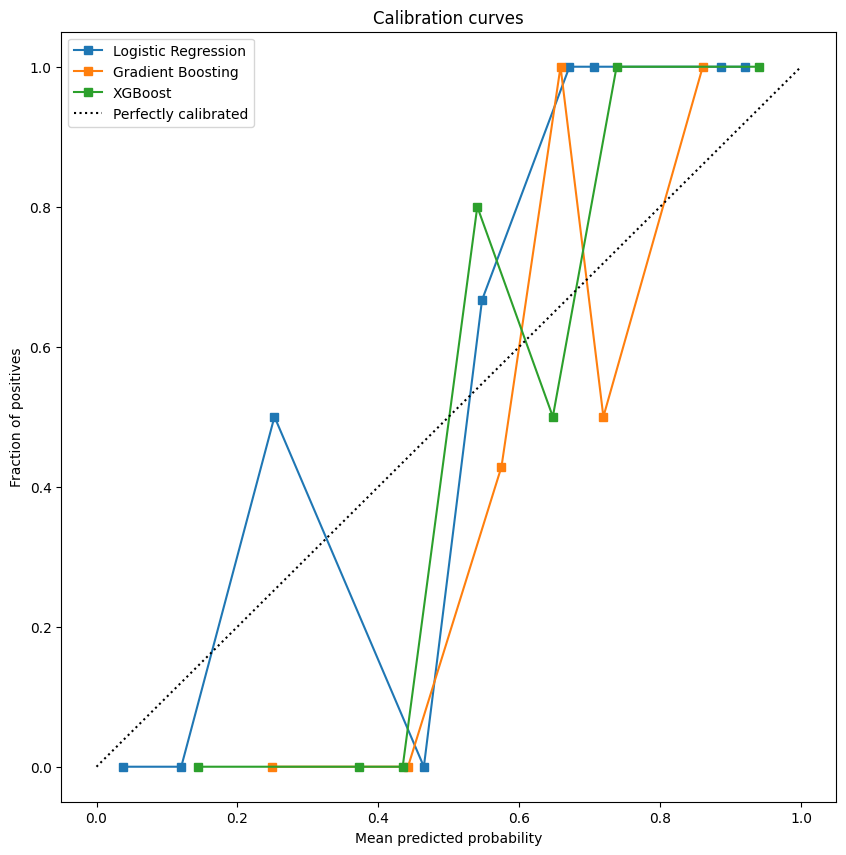

In [43]:
# Plot calibration curves
plt.figure(figsize=(10, 10))
for name, model in best_models.items():
    if name in top_model_names and hasattr(model, "predict_proba"):
        prob_pos = model.predict_proba(X_test_scaled)[:, 1]
        fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
        plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{name}")

plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves")
plt.legend()
plt.show()
plt.savefig('calibration_curves.png')
plt.close()

In [44]:
# ----- Ensemble Modeling -----
print("\n----- Ensemble Modeling -----")

# Get top model objects
top_model_objects = [(name, best_models[name]) for name in top_model_names]

print(f"Using top 3 models for ensemble: {top_model_names}")



----- Ensemble Modeling -----
Using top 3 models for ensemble: ['XGBoost', 'Logistic Regression', 'Gradient Boosting']


In [45]:
# Voting Classifier
voting_clf = VotingClassifier(estimators=top_model_objects, voting='soft')
voting_clf.fit(X_train_scaled, y_train)
y_pred_voting = voting_clf.predict(X_test_scaled)
y_prob_voting = voting_clf.predict_proba(X_test_scaled)[:, 1]

# Weighted voting based on validation performance
weights = [model_metrics[name]['F1-score'] for name in top_model_names]
weighted_voting_clf = VotingClassifier(
    estimators=top_model_objects, 
    voting='soft',
    weights=weights
)
weighted_voting_clf.fit(X_train_scaled, y_train)
y_pred_weighted = weighted_voting_clf.predict(X_test_scaled)
y_prob_weighted = weighted_voting_clf.predict_proba(X_test_scaled)[:, 1]

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=top_model_objects,
    final_estimator=LogisticRegression()
)
stacking_clf.fit(X_train_scaled, y_train)
y_pred_stacking = stacking_clf.predict(X_test_scaled)
y_prob_stacking = stacking_clf.predict_proba(X_test_scaled)[:, 1]

In [46]:
# Evaluate ensemble models
print("\nVoting Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_voting))
print("F1 Score:", f1_score(y_test, y_pred_voting))
print("AUC-ROC:", roc_auc_score(y_test, y_prob_voting))
print("Classification Report:")
print(classification_report(y_test, y_pred_voting))

print("\nWeighted Voting Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_weighted))
print("F1 Score:", f1_score(y_test, y_pred_weighted))
print("AUC-ROC:", roc_auc_score(y_test, y_prob_weighted))
print("Classification Report:")
print(classification_report(y_test, y_pred_weighted))

print("\nStacking Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_stacking))
print("F1 Score:", f1_score(y_test, y_pred_stacking))
print("AUC-ROC:", roc_auc_score(y_test, y_prob_stacking))
print("Classification Report:")
print(classification_report(y_test, y_pred_stacking))


Voting Classifier Results:
Accuracy: 0.7619047619047619
F1 Score: 0.7826086956521738
AUC-ROC: 0.9090909090909091
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.75      0.82      0.78        11

    accuracy                           0.76        21
   macro avg       0.76      0.76      0.76        21
weighted avg       0.76      0.76      0.76        21


Weighted Voting Classifier Results:
Accuracy: 0.7619047619047619
F1 Score: 0.7826086956521738
AUC-ROC: 0.9090909090909091
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.75      0.82      0.78        11

    accuracy                           0.76        21
   macro avg       0.76      0.76      0.76        21
weighted avg       0.76      0.76      0.76        21


Stacking Classifier Results:
Accuracy: 0.8095238095238095
F1 S

In [47]:
# ----- Final Model Selection -----
print("\n----- Final Model Selection -----")

# Add ensemble models to the metrics dictionary
model_metrics["Voting Ensemble"] = {
    'Accuracy': accuracy_score(y_test, y_pred_voting),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_voting),
    'F1-score': f1_score(y_test, y_pred_voting),
    'AUC-ROC': roc_auc_score(y_test, y_prob_voting)
}

model_metrics["Weighted Voting Ensemble"] = {
    'Accuracy': accuracy_score(y_test, y_pred_weighted),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_weighted),
    'F1-score': f1_score(y_test, y_pred_weighted),
    'AUC-ROC': roc_auc_score(y_test, y_prob_weighted)
}

model_metrics["Stacking Ensemble"] = {
    'Accuracy': accuracy_score(y_test, y_pred_stacking),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_stacking),
    'F1-score': f1_score(y_test, y_pred_stacking),
    'AUC-ROC': roc_auc_score(y_test, y_prob_stacking)
}

# Find the best model based on F1 score (balances precision and recall)
best_model_name = max(model_metrics, key=lambda x: model_metrics[x]['F1-score'])
print(f"Best model: {best_model_name}")
print("Metrics:", model_metrics[best_model_name])


----- Final Model Selection -----
Best model: XGBoost
Metrics: {'Accuracy': 0.8571428571428571, 'Balanced Accuracy': 0.85, 'F1-score': 0.88, 'AUC-ROC': 0.8999999999999999}


In [48]:
# Get the actual best model object
if best_model_name == "Voting Ensemble":
    best_model = voting_clf
    final_predictions = y_pred_voting
    final_probabilities = y_prob_voting
elif best_model_name == "Weighted Voting Ensemble":
    best_model = weighted_voting_clf
    final_predictions = y_pred_weighted
    final_probabilities = y_prob_weighted
elif best_model_name == "Stacking Ensemble":
    best_model = stacking_clf
    final_predictions = y_pred_stacking
    final_probabilities = y_prob_stacking
else:
    best_model = best_models[best_model_name]
    final_predictions = best_model.predict(X_test_scaled)
    final_probabilities = best_model.predict_proba(X_test_scaled)[:, 1]

In [49]:
# ----- Final Predictions with Probabilities -----
print("\n----- Final Predictions with Probabilities -----")

# Get original test dates
test_dates = data['date'].iloc[train_size:].reset_index(drop=True)

# Create final predictions dataframe with confidence intervals
final_results = pd.DataFrame({
    'Date': test_dates,
    'Actual': y_test.values,
    'Predicted': final_predictions,
    'Probability_of_Rain': final_probabilities
})

# Add confidence intervals
final_results['Lower_CI'] = final_results['Probability_of_Rain'] - 1.96 * np.sqrt(final_results['Probability_of_Rain'] * (1 - final_results['Probability_of_Rain']) / len(X_train))
final_results['Upper_CI'] = final_results['Probability_of_Rain'] + 1.96 * np.sqrt(final_results['Probability_of_Rain'] * (1 - final_results['Probability_of_Rain']) / len(X_train))

# Constrain confidence intervals to valid probability range
final_results['Lower_CI'] = final_results['Lower_CI'].clip(0, 1)
final_results['Upper_CI'] = final_results['Upper_CI'].clip(0, 1)

# Add decision guidance
final_results['Recommendation'] = np.where(
    final_results['Probability_of_Rain'] > 0.7, 
    'High confidence of rain - prepare accordingly',
    np.where(
        final_results['Probability_of_Rain'] > 0.4,
        'Moderate chance of rain - consider precautions',
        'Low probability of rain - normal operations'
    )
)

print("\nFinal Predictions for the 21 test days:")
print(final_results)


----- Final Predictions with Probabilities -----

Final Predictions for the 21 test days:
         Date  Actual  Predicted  Probability_of_Rain  Lower_CI  Upper_CI  \
0  2023-10-18       1          1             0.735871  0.684595  0.787146   
1  2023-10-19       1          1             0.940847  0.913409  0.968284   
2  2023-10-20       1          1             0.940847  0.913409  0.968284   
3  2023-10-21       0          1             0.669001  0.614271  0.723731   
4  2023-10-22       1          1             0.619357  0.562886  0.675828   
5  2023-10-23       1          1             0.552934  0.495109  0.610760   
6  2023-10-24       1          1             0.940847  0.913409  0.968284   
7  2023-10-25       0          1             0.606628  0.549813  0.663443   
8  2023-10-26       1          1             0.695767  0.642258  0.749277   
9  2023-10-27       1          1             0.509975  0.451834  0.568115   
10 2023-10-28       0          1             0.551224  0.49337

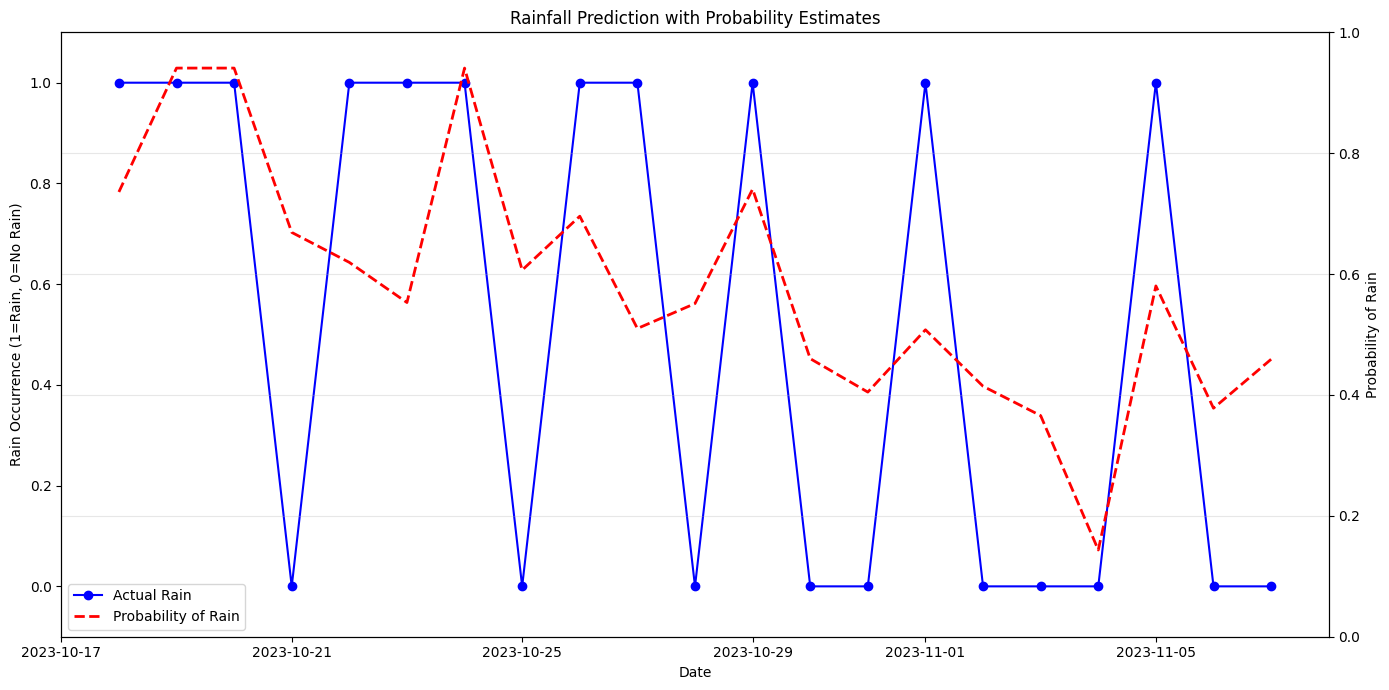

<function matplotlib.pyplot.savefig(*args, **kwargs)>

In [50]:
# Enhanced visualization of predictions
from matplotlib.dates import DateFormatter

fig, ax1 = plt.subplots(figsize=(14, 7))
ax2 = ax1.twinx()

# Plot actual values
ax1.plot(final_results['Date'], final_results['Actual'], 'bo-', label='Actual Rain')
ax1.set_ylim(-0.1, 1.1)
ax1.set_ylabel('Rain Occurrence (1=Rain, 0=No Rain)')
ax1.set_xlabel('Date')

# Plot probabilities
ax2.plot(final_results['Date'], final_results['Probability_of_Rain'], 'r--', label='Probability of Rain', linewidth=2)
ax2.set_ylim(0, 1)
ax2.set_ylabel('Probability of Rain')

# Format the x-axis to show dates clearly
date_format = DateFormatter('%Y-%m-%d')
ax1.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=45)

# Add both legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.title('Rainfall Prediction with Probability Estimates')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig